# CarND---Vehicle Detection Project

The files of this project are listed as below:
* Writeup: this readme file you are reading now;
* the `*.ipynb` format code: `CarND-Vehicle Detection Project Report.ipynb`;
* the `*.py` format code: `proj5.py`; and
* the processed video: `result.mp4`

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Section 1: Histogram of Oriented Gradients (HOG)

### 1.1: Data Collection 

I started by reading in all the [`vehicle`](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [`non-vehicle`](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images. The following code blocks are for loading data. One of the images is randomly picked as shown below.

In [1]:
# import packages:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

A count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


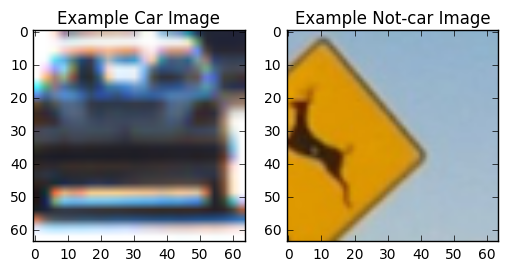

In [2]:
# images are divided up into vehicles and non-vehicles
cars = [] # The links of cars
notcars = [] # The links of notcars

# Using glob is so easy to load files...
images = glob.glob('vehicles/GTI*/*')
for image in images:
    cars.append(image)
images = glob.glob('vehicles/KITTI*/*')
for image in images:
    cars.append(image)
images = glob.glob('non-vehicles/GTI/*')
for image in images:
    notcars.append(image)
images = glob.glob('non-vehicles/Extras/*')
for image in images:
    notcars.append(image)
    

        
# Define a function to return some characteristics of the dataset 
# Importantly, I want know whether the dataset is balance. 
# That is, the number of cars and the number of nocars have to be similar.

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('A count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### 1.2: Feature Extraction

The purpose of feature extraction is to extract features from raw images to represent the raw images. That is, we can use features of an image to represent that image. Therefore, we can use features of images to train a classifier, and also use features for evaluation.

There are many methods for extracting features: color histogram features (`color_hist()`), spatial binning of colors (`bin_spatial()`), and histogram of oriented gradients (HOG) features (`get_hog_features()`). Our main method is HOG Features.

In order to extract HOG features, I adopted the `hog` function. The whole process is wraped in the function `get_hog_features`.

There are many parameters, including `orient`, `pix_per_cell`, and `cell_per_block`, etc. I did not have a particular good method for setting these parameters, just trial and error.

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In what follows, the `orient=9`, `pix_per_cell = 8` and `cell_per_block = 2`. An image of one car is selected and shown along with the HOG visualization.

(7, 7, 2, 2, 9)


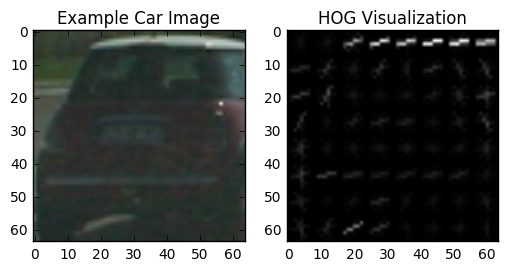

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
print(np.shape(features))


# Plot the examples
fig = plt.figure()
plt.subplot(121)
#plt.imshow(hog_image, cmap='gray')
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### Define a function to compute binned color features

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#### Define a function to compute color histogram features 

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### Define a function to extract features from a list of images. Have this function call `bin_spatial()`,  `color_hist()`, and `get_hog_features()`.

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

The following code block specifies the related parameters. `xy_overlap` specifies the overlap between two adjacent  sliding windows. I have to balance the processing time and the performance, so I set it to $0.75$, because I feel that $0.5$ is not enough. `y_start_stop` and `x_start_stop` are the ranges of sliding windows. Note that I tried almost all the color_space, I feel 'YCrCb' is better. Other parameters are based on trial and error.

In [8]:
# These are the values used in the, svc, classifier
# performs under different binning scenarios
xy_overlap = (0.75, 0.75)
y_start_stop = [400, 700] # Min and max in y to search in slide_window()
x_start_stop = [750,1280]
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

All the raw images, including cars and notcars, are taken into consideration. Note that they are almost balanced. 

In [9]:
import time
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(np.shape(car_features))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

(8792, 8460)
104.95 Seconds to extract HOG features...


### 1.3: Data Preparation and Training a Classifier

In what follows, features are scaled to zero mean and unit variance before training the classifier.

In [10]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
print(np.shape(X))
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

(17760, 8460)


I split up the data into randomized training and test sets. The portion of test data is $20\%$.

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Support vector classifier is used as below. Note that linear function is selected as the kernel function. The code is: `svc=LinearSVC()`. I used $9$ orientations, $8$ pixels per cell, and $2$ cells per block.

In [12]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
12.82 Seconds to train SVC...


The accuracy of SVC is checked as below. I tried this several times, the accuracy always higher than $97.5\%$.

In [13]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
0.019 Seconds to predict 10 labels with SVC


## Section 2: Sliding Window Search

### 2.1: Sliding Windows

In this subsection, sliding windows are used for detecting whether there is a car appears in an image.

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    #image = img.astype(np.float32)/255
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Note that the larger the overlap, the processing time is longer, but the performance would be better. I show two of different overlap settings: one is $0.50$, and the other is $0.75$.

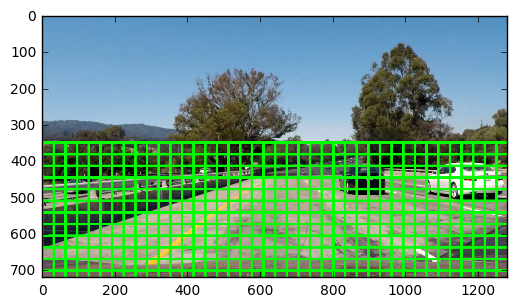

In [16]:
image = mpimg.imread('test_images/test1.jpg')
image = np.copy(image)

windows = slide_window(image, x_start_stop=[0,1280], y_start_stop=[350,700], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)                    
plt.imshow(window_img)

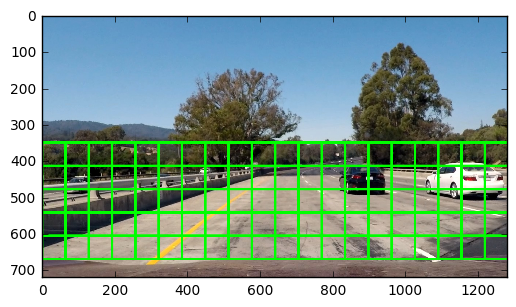

In [17]:
image = mpimg.imread('test_images/test1.jpg')
image = np.copy(image)

windows = slide_window(image, x_start_stop=[0,1280], y_start_stop=[350,700], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)                    
plt.imshow(window_img)

### 2.2: Search and Classify

From the sliding windows obtained in the previously subsection, a set of cut-off images could be obtained. Then, by the trained SVC, each cut-off image can be evaluated. 

In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [19]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel= hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat):


    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

There are  $8$ different window sizes, the numbers are the multiples of $12$, from $60$ to $144$. The min and max numbers are obtained by measuring the length a near car and a far car.

In [20]:
def slide_windows_collection(img):
    # create an empty list to append all windows
    all_windows = []
    for size in [60,72,84,96,108,120,132,144]:
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(size, size), xy_overlap=xy_overlap)
        all_windows += windows
    return all_windows

In [21]:
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/test5.jpg')
normalized_image=np.copy(image)
normalized_image = normalized_image.astype(np.float32)/255
draw_image = np.copy(normalized_image)

In [22]:
windows = slide_windows_collection(normalized_image)
#windows = slide_window(normalized_image)

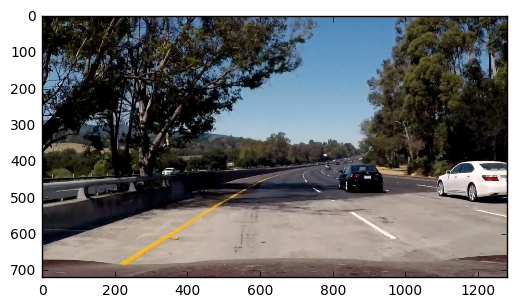

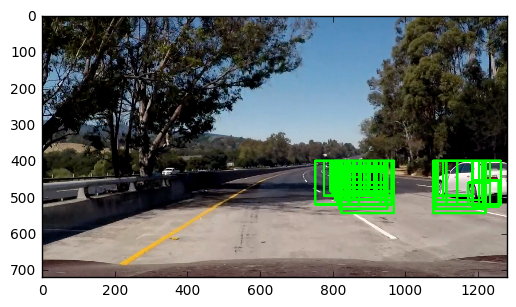

In [23]:
hot_windows = search_windows(normalized_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 1, 0), thick=6)                    
plt.figure()
plt.imshow(normalized_image)
plt.figure()
plt.imshow(window_img)

### 2.3: Remove False Positives

In this subsection, I try to remove false positives. An assumption is that: for a false positive, there are fewer sliding boxes on it; on the other hand, for a true positive, there are more sliding windows on it. Thus, we can set a threshold to remove out the false positives.

In [24]:
#all_bboxes are the hot_windows
def add_heat(heatmap, all_bboxes):
    # Iterate through list of bboxes
    for box in all_bboxes:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In what follows, `add_heat()` function is used to remove false positives. 

In [26]:
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
heat_threshold = 2

In [27]:
#labels is a 2-tuple, where the first item is an array the size 
#of the heatmap input image and the second element is the number 
#of labels (cars) found.
from scipy.ndimage.measurements import label
heatmap = add_heat(heat, hot_windows)

2 cars found


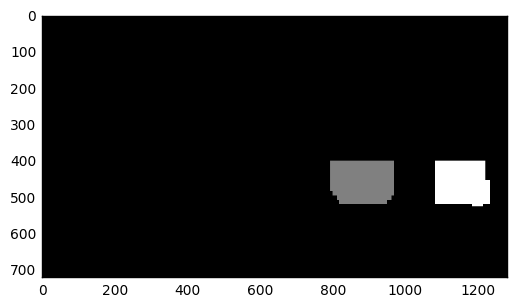

In [28]:
heatmap = apply_threshold(heatmap, heat_threshold)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

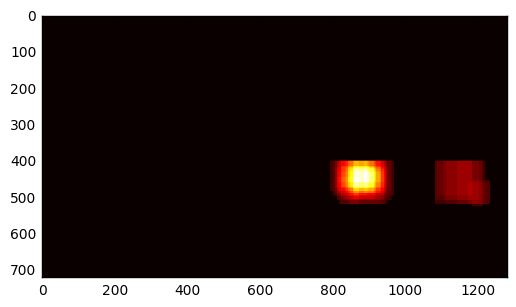

In [29]:
plt.imshow(heatmap, cmap='hot')

In [30]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,1,0), 6)
    # Return the image
    return img

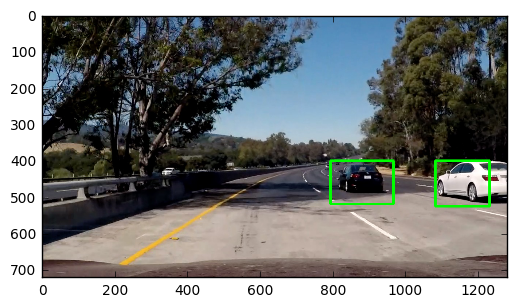

In [31]:
# Read in the last image above
image = np.copy(normalized_image)
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

## Section 3: Pipeline and Test

In this section, I put the above functions together for testing and generating output video.

### 3.1: Pipeline

In [33]:
def pipeline(image):
    
    def add_heat(heatmap, all_bboxes):
        # Iterate through list of bboxes
        for box in all_bboxes:
            # Add += 1 for all pixels inside each bbox
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap

    def apply_threshold(heatmap, threshold=1):
            # Zero out pixels below the threshold
            heatmap[heatmap <= threshold] = 0
            # Return thresholded map
            return heatmap
    
    
    # These are the values used in the, svc, classifier
    # performs under different binning scenarios
    xy_overlap = (0.75, 0.75)
    #y_start_stop = [340, 680] # Min and max in y to search in slide_window()
    #x_start_stop = [760, 1260]
    y_start_stop = [400,700] # Min and max in y to search in slide_window()
    x_start_stop = [750,1280]
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    vis = True

    normalized_image=np.copy(image)
    normalized_image = normalized_image.astype(np.float32)/255
    draw_image = np.copy(normalized_image)
    #plt.figure()
    #plt.imshow(normalized_image)
    
    windows = slide_windows_collection(normalized_image)
    hot_windows = search_windows(normalized_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 1, 0), thick=6)                    

    #plt.figure()
    #plt.imshow(window_img)
    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    #print(np.shape(heat))
    heat_threshold = 2
    
    from scipy.ndimage.measurements import label
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, heat_threshold)
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    #plt.figure()
    #plt.imshow(labels[0], cmap='gray')

    #plt.figure()
    #plt.imshow(heatmap, cmap='hot')
    #..................................
    image = np.copy(normalized_image)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    # return the image
    draw_img=draw_img*255
    draw_img=draw_img.astype(np.uint8)
    #draw_img = cv2.cvtColor(draw_img,cv2.COLOR_YCrCb2RGB)
    return draw_img
    #plt.figure()
    #plt.imshow(draw_img)

### 3.2: Test on Images

In [34]:
import glob
images = glob.glob('test_images/*.jpg')

In [35]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

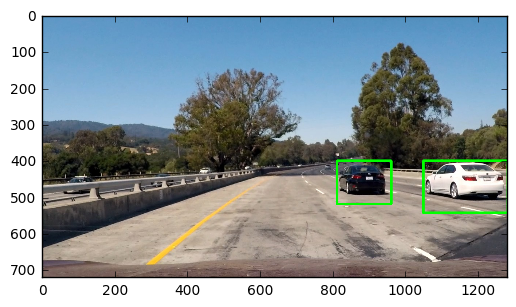

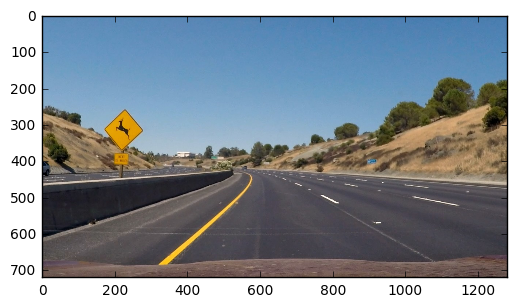

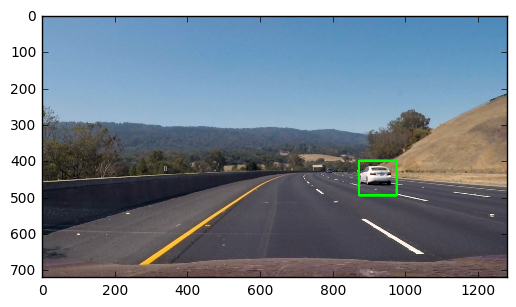

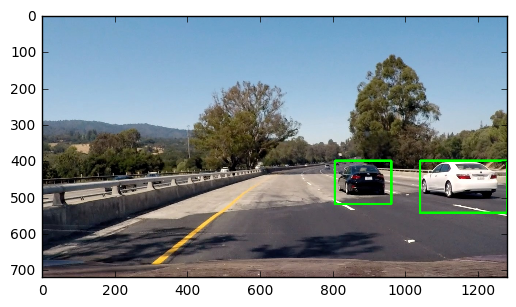

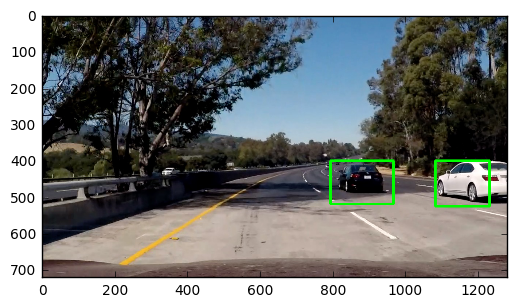

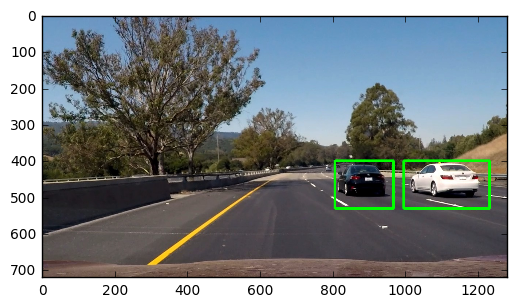

In [36]:
for imagepath in images:
    #image = mpimg.imread(imagepath)
    img = cv2.imread(imagepath)
    image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #pipeline(image)
    result=pipeline(image)
    plt.figure()
    plt.imshow(result)

## Section 4: Video Implementation

The following codes are used for processing video file. The steps includes: reading a video clip, processing the clip, and writing a processed video.

In [ ]:
from moviepy.editor import VideoFileClip

video_output = 'test0.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("test_video.mp4", audio=False)
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)

## Section 5: Discussion

(Note: This iPython Notebook file is just for presentation, a standalone python code is named as proj5.py. The result video file is result.mp4.)

From this project, I eventually know how to preprocess data, to extract features, to train a classifier, to detect a car using sliding windows, and to remove false positives, etc. Of course, robustness is an issue. However, I feel there is an important issue I have not touched, that is, how to design and implement a real-time car detector. The provided movie clip is 50 seconds long, but it takes me 4 hours to process it! So, the next step for me is to consider how to implement a real-time detector. I will find the bottlenecks of the pipeline, and try to use another more efficient method to achieve the same or better results.